## 3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

In [3]:
# Cargo el dataframe preprocesado

import pandas as pd

df_videogames_processed = pd.read_csv("df_videogames_processed.csv", sep=',')

In [4]:
# Creo los conjuntos de entrenamiento (70%) y test (30%)
# Descargo las librerías necesarias para el modelado

!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df_videogames_processed['processedreviews'], df_videogames_processed['sentiment_label'], train_size=0.70, test_size=0.3,
                                                    random_state=1, shuffle=True)

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2950 sha256=9b933b9733d507637ead6d5982bc25370b75d122431bd22a09d48e6cceee07a0
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [5]:
# Extraigo las características, decido utilizar vectorización TF-IDF
# Establezco un número máximo de carácterísticas de 4500 (palabras) y un mínimo de apariciones de 3, todo para palabras individuales.

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=4500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=4500, min_df=3, strip_accents='ascii')

In [6]:
# Observo por pantalla los 25 últimos términos del vocabulario

list(cv.vocabulary_.items())[:25]

# Comprueblo que la longitud del vocabulario es la fijada

len(cv.vocabulary_)

4500

In [7]:
# Vectorizo los set de train y test

X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

# Comienzo el entrenamiento y predicción para un primer modelo sencillo de machine learning: regresión logística
# Hago pruebas con hasta 5 valores distintos para el parámetro 'c' e imprimo por pantalla el accuracy para las distintas predicciones/valores de 'c'

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_params = [0.01, 0.5, 1, 100, 1000, 10000]

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=10000)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

Accuracy for C=0.01: 0.7706684627041589
Accuracy for C=0.5: 0.8242128304428354
Accuracy for C=1: 0.8280013470281192
Accuracy for C=100: 0.8056070045462199
Accuracy for C=1000: 0.7967671325138912
Accuracy for C=10000: 0.7957568614244822


Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END ........................................max_depth=1; total time=   3.9s
[CV] END ........................................max_depth=1; total time=   3.2s
[CV] END ........................................max_depth=1; total time=   3.0s
[CV] END ........................................max_depth=1; total time=   4.8s
[CV] END ........................................max_depth=1; total time=   3.8s
[CV] END ........................................max_depth=2; total time=   3.8s
[CV] END ........................................max_depth=2; total time=   3.8s
[CV] END ........................................max_depth=2; total time=   4.7s
[CV] END ........................................max_depth=2; total time=   3.9s
[CV] END ........................................max_depth=2; total time=   4.1s
[CV] END ........................................max_depth=3; total time=   5.7s
[CV] END .......................................

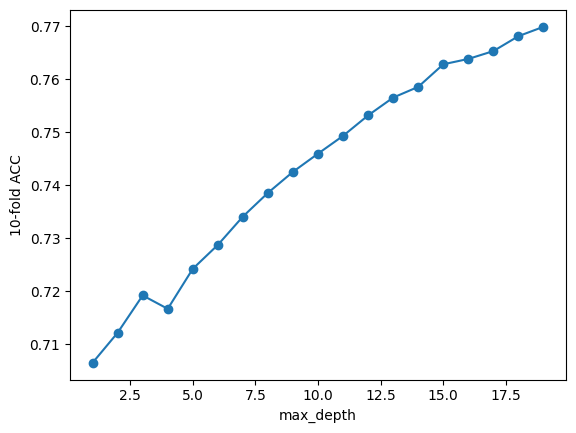

In [ ]:
# Comienzo el entrenamiento para el segundo modelo de machine learning, algo más complejo que el anterior: random forest

# Ajustaré parámetros a través de grid search, importo librerías necesarias para ello y para posterior visualización

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Lanzo el train con grid search para encontrar el valor óptimo para el parámetro 'max_depth'
maxDepth = range(1,20)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=500, max_features='sqrt'),  scoring='accuracy', param_grid=tuned_parameters,cv=5, verbose=2)
grid.fit(X_train_, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Visualizo resultados para los distintos valores probados con grid search con objeto de asegurar que el valor óptimo encontrado no corresponde a un mínimo local
scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')
plt.show()

# Observo que aún no he alcanzado el valor óptimo de depth, lanzo de nuevo grid search para valores de 'depth' más altos

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................................max_depth=20; total time=  30.0s
[CV] END .......................................max_depth=20; total time=  29.4s
[CV] END .......................................max_depth=20; total time=  28.5s
[CV] END .......................................max_depth=20; total time=  29.1s
[CV] END .......................................max_depth=20; total time=  29.2s
[CV] END .......................................max_depth=25; total time=  39.8s
[CV] END .......................................max_depth=25; total time=  39.6s
[CV] END .......................................max_depth=25; total time=  40.4s
[CV] END .......................................max_depth=25; total time=  44.7s
[CV] END .......................................max_depth=25; total time=  40.2s
[CV] END .......................................max_depth=35; total time= 1.1min
[CV] END .......................................m

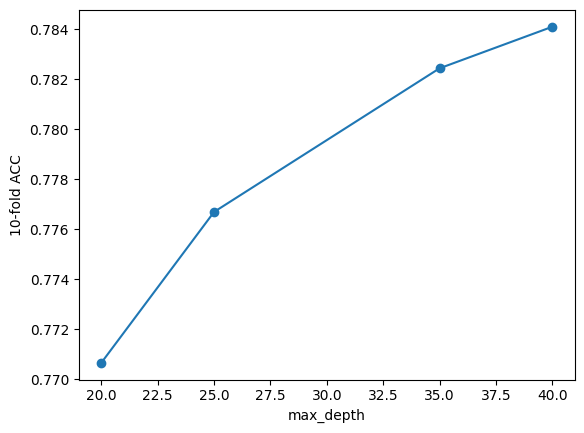

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

maxDepth = [20, 25, 35, 40]
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=500, max_features='sqrt'),  scoring='accuracy', param_grid=tuned_parameters,cv=5, verbose=2)
grid.fit(X_train_, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Visualizo los resultados para los nuevos valores probados con grid search con objeto de asegurar que el valor óptimo encontrado no corresponde a un mínimo local
scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')
plt.show()

# Observo que los resultados de un 'depth' de entre 35 y 40 mejoran muy poco, por lo que fijo el mejor valor para el parámetro en 40

In [10]:
# Encontrado un valor óptimo para max_depth entreno el modelo con el conjunto de train

maxDepthOptimo = grid.best_params_['max_depth']
rf = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=500,max_features='sqrt').fit(X_train_, y_train)

# Entrenado el modelo calculo accuracy para test
print("Test: ",rf.score(X_test_, y_test))

# Con esto doy por finalizado el segundo modelo, obteniendo un accuracy ligeramente inferior al obtenido con regresión logística

Test:  0.7876746927092103


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................................max_depth=15; total time=   2.5s
[CV] END .......................................max_depth=15; total time=   2.5s
[CV] END .......................................max_depth=15; total time=   3.3s
[CV] END .......................................max_depth=15; total time=   2.5s
[CV] END .......................................max_depth=15; total time=   2.5s
[CV] END .......................................max_depth=25; total time=   5.0s
[CV] END .......................................max_depth=25; total time=   5.5s
[CV] END .......................................max_depth=25; total time=   5.0s
[CV] END .......................................max_depth=25; total time=   5.5s
[CV] END .......................................max_depth=25; total time=   5.1s
[CV] END .......................................max_depth=35; total time=   7.3s
[CV] END .......................................m

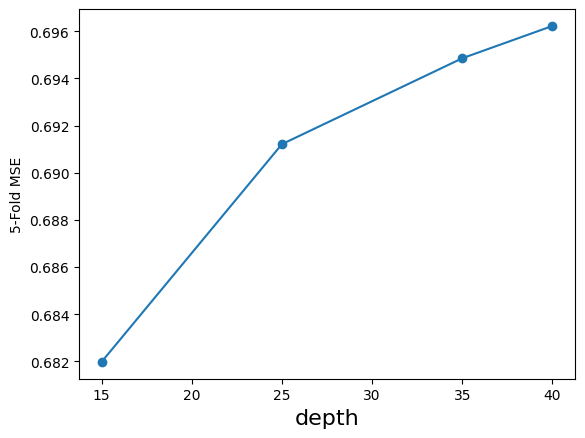

In [11]:
# Decido probar con un tercer y último modelo de machine learning, con una complejidad intermedia entre los dos modelos anteriores: árbol de decisión simple
# Utilizo de nuevo grid search para encontrar los valores óptimos

from sklearn.tree import DecisionTreeClassifier

max_depth_vector = [15, 25, 35, 40]
param_grid = {'max_depth': max_depth_vector }
grid = GridSearchCV(DecisionTreeClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5, verbose=2)
grid.fit(X_train_, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(max_depth_vector,scores,'-o')
plt.xlabel('depth',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

# Observo que el accuracy en train es considerablemente inferior al de los modelos anteriores, no obstante decido terminar con el análisis

In [12]:
# Fijo 40 como valor óptimo para max_depth entreno el modelo con el conjunto de train

maxDepthOptimo = grid.best_params_['max_depth']
dt = DecisionTreeClassifier(max_depth=maxDepthOptimo,max_features='sqrt').fit(X_train_, y_train)

# Entrenado el modelo calculo accuracy para test
print("Test: ",dt.score(X_test_, y_test))

# Con esto doy por finalizado el tercer modelo, obteniendo un accuracy muy inferior al obtenido con los dos modelos anteriores

Test:  0.6585283717797609


## 4. Reporte de métricas y conclusiones

In [15]:
# Descargamos librerías necesarias para reporting

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Report del modelo 1: Regresión logística

lr = LogisticRegression(C=1, solver='lbfgs', max_iter=10000)
lr.fit(X_train_, y_train)
test_predict = lr.predict(X_test_)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[5027  970]
 [1073 4808]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      5997
         1.0       0.83      0.82      0.82      5881

    accuracy                           0.83     11878
   macro avg       0.83      0.83      0.83     11878
weighted avg       0.83      0.83      0.83     11878

Accuracy score:0.8280013470281192


In [16]:
# Report del modelo 2: Random forest

test_predict2 = rf.predict(X_test_)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict2)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict2)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict2)))

Confussion matrix:
[[4658 1339]
 [1183 4698]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      5997
         1.0       0.78      0.80      0.79      5881

    accuracy                           0.79     11878
   macro avg       0.79      0.79      0.79     11878
weighted avg       0.79      0.79      0.79     11878

Accuracy score:0.7876746927092103


In [17]:
# Report del modelo 3: Decision tree

test_predict3 = dt.predict(X_test_)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict3)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict3)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict3)))

Confussion matrix:
[[4901 1096]
 [2960 2921]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.62      0.82      0.71      5997
         1.0       0.73      0.50      0.59      5881

    accuracy                           0.66     11878
   macro avg       0.68      0.66      0.65     11878
weighted avg       0.67      0.66      0.65     11878

Accuracy score:0.6585283717797609


# Conclusiones

El testeo de los diferentes modelos demuestra que no siempre los más complejos arrojan mejores resultados. En este caso un modelo simple de regresión logística consigue un accuracy sensiblemente superior al de modelos más complejos como random forest o decision tree.
El análisis demuestra la importancia de utilizar técnicas de grid para la optimización de parámetros en la obtención de los mejores resultados.
Respecto a las métricas, más allá de lo apuntado acerca del accuracy, decir que hay cierto balanceo entre los falsos negativos y los falsos positivos, salvo en el modelo de decision tree simple donde los falsos negativos se disparan, fallando la predicción negativa en algo más del 50% de los casos.

Por último, y dado que ya se han ido desgranando conclusiones en los notebooks anteriores, finalizar apuntando que, una vez más, la práctica desarrollada demuestra la importancia (se ha llevado en torno al 70% del tiempo empleado) de un buen preprocesado en la optimización de los análisis y la obtención de buenos resultados.

A futuro, invirtiendo algo de tiempo extra, los modelos de la práctica se podrían mejorar ampliando el vocabulario, optimizando aún más el preprocesado y probando/optimizando más parámetros de grid search. También podrían mejorar resultados, previsiblemente, los modelos de deep learning. No obstante el modelo de regresión logística desarrollado arroja ya un 83% de accuracy, lo cual no está nada mal dada la complejidad del problema y demuestra el potencial de las técnicas de machine learning aplicadas al NLP.

Un gran modulo este de NLP. Seguimos! :-)